In [1]:
!pip install optuna catboost -q
!pip install boruta -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 558.6 kB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch
import optuna
from optuna.samplers import TPESampler

from optuna.integration import CatBoostPruningCallback
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

from joblib import dump, load

In [4]:
def set_all_seeds(seed):

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


dseed = 42
set_all_seeds(seed=dseed)

In [5]:
link = '/content/drive/MyDrive/MISIS_edu_huck/'
train_df = pd.read_csv(link+'train.csv', header=None)
train_target = pd.read_csv(link+'train-target.csv', header=None)
test_df = pd.read_csv(link+'test.csv', header=None)
sample_sub = pd.read_csv(link+'sample-submission.csv', header=None)

In [6]:
train_df.rename(columns=lambda x: str(x), inplace=True)
train_target.rename(columns={0: 'class'}, inplace=True)
test_df.rename(columns=lambda x: str(x), inplace=True)

In [7]:
df = train_df.copy()
df['target'] = train_target['class']
transform_df = df.drop(['9', '15', '16', '26'], axis=1)  # leak data

In [9]:
transform_df.head()

,0,1,2,3,4,5,6,7,8,10,...,22,23,24,25,27,28,29,target,sum_in_row,dop
0,-220.530530,-70.197440,119.035181,20.711737,-6.152986,52.225051,-23.230903,-166.521871,-41.571463,271.292251,...,-80.962171,-146.652218,10.899085,4.370985,40.680890,-37.942655,33.838225,1,-159.783627,55.761062
1,-8.536541,-8.305435,-117.828269,-28.588333,14.223240,-42.087807,-45.538664,58.898976,27.749744,-97.233793,...,31.507396,88.282912,66.766185,-4.363974,-32.101939,-52.255449,-4.826111,1,-123.142391,-30.723152
2,126.229973,133.463504,-105.511797,-149.110267,-3.673355,-104.302244,5.815395,100.838385,-46.240211,194.054804,...,51.475105,-73.257358,108.947287,8.567240,-117.205053,-107.835928,-93.990332,0,-123.375258,12.649001
3,369.571563,11.850181,-299.969407,29.371721,-3.457523,-115.901854,159.134323,-149.741411,-108.847522,-215.802195,...,-73.882682,108.222355,19.573192,-2.242024,-25.218215,121.674228,-16.877368,0,-248.656020,-73.681657
4,-99.563708,-85.166292,-73.363391,-35.357907,5.437025,-54.892519,56.430532,-49.237377,-50.054608,-115.997344,...,-22.847302,-62.067337,58.109167,2.862082,-132.875142,3.492953,-15.799596,1,-413.528594,-27.051534


## Zero_stap (The leak)

Первый submitte дал результат **0.51** -> после анализы в данных была найдена утечка

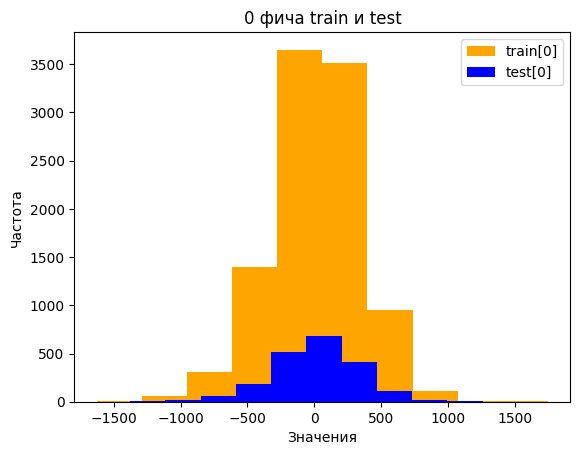

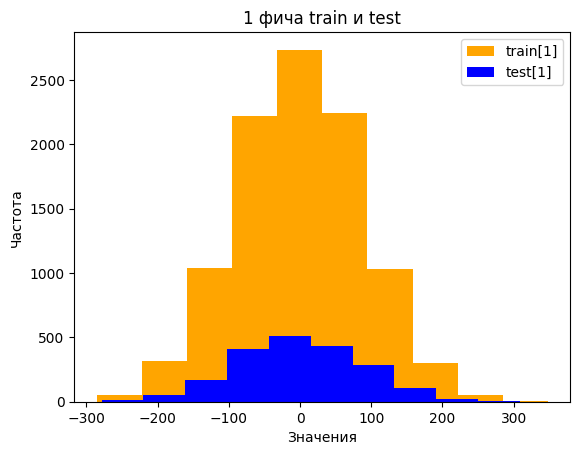

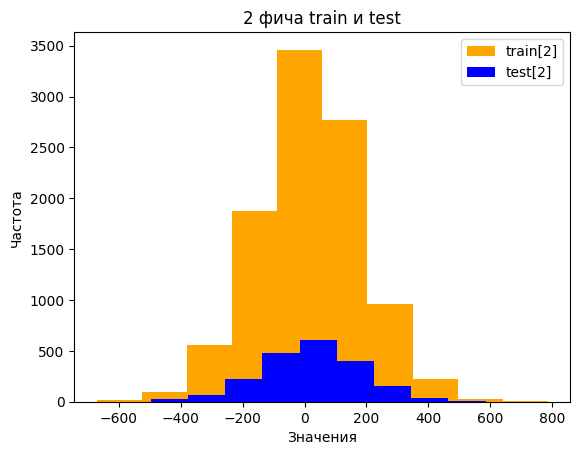

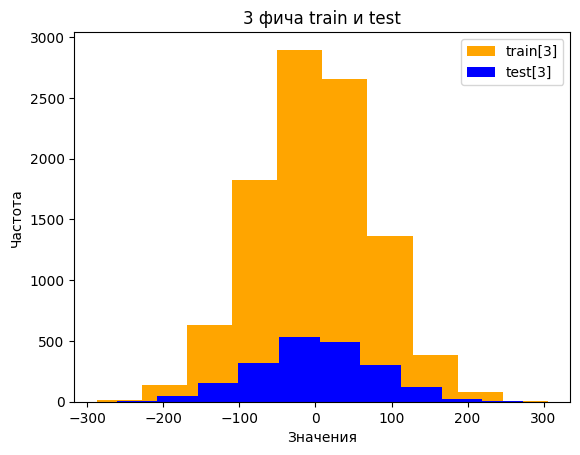

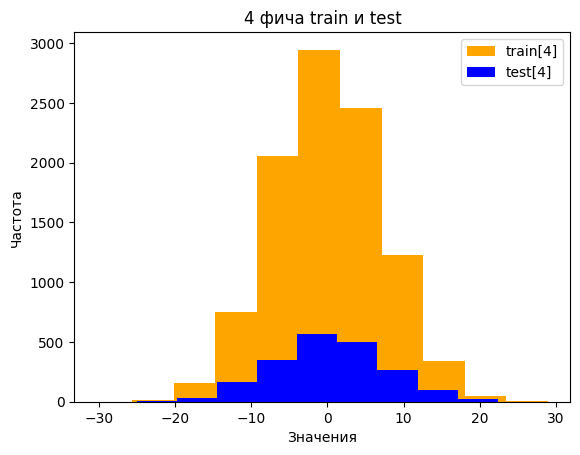

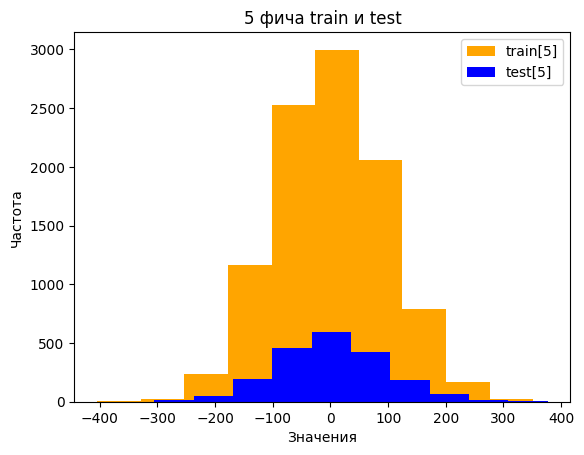

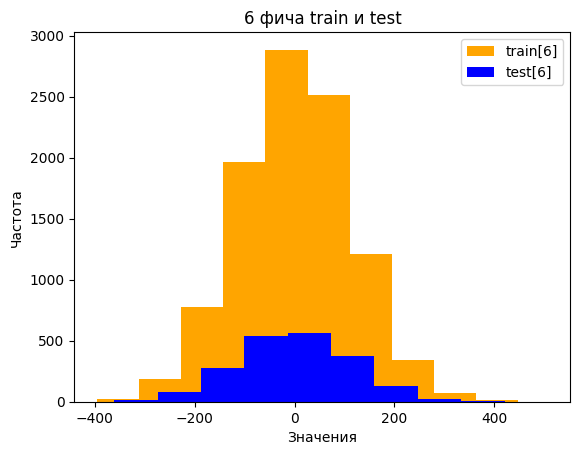

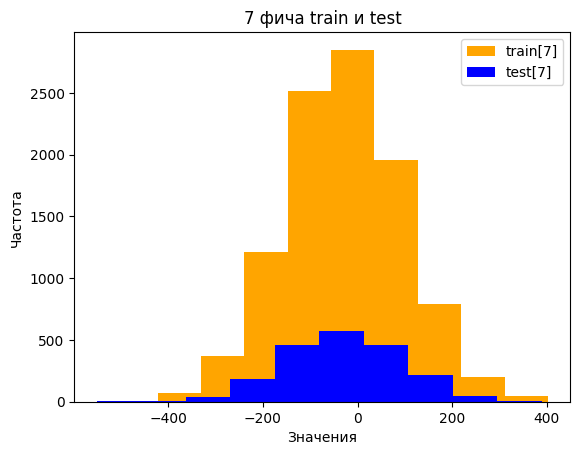

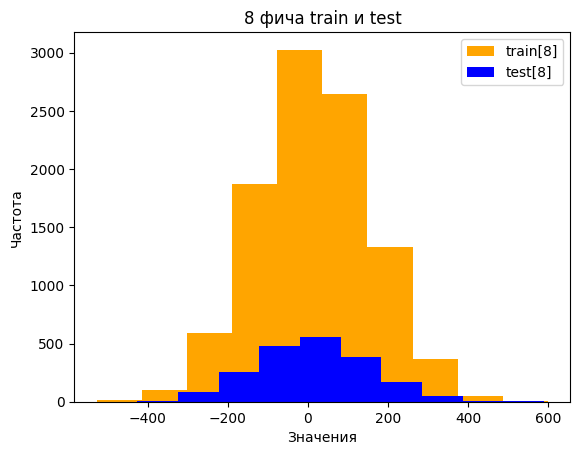

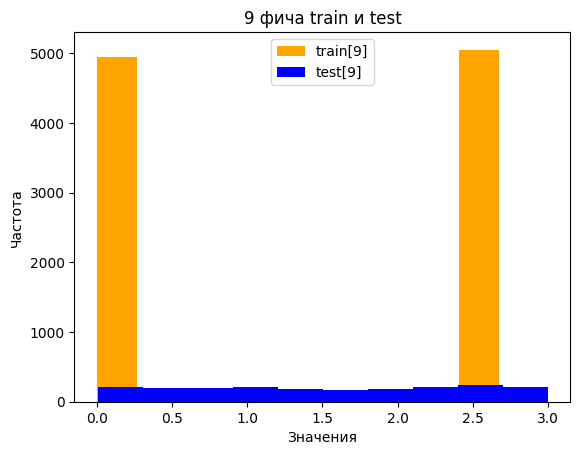

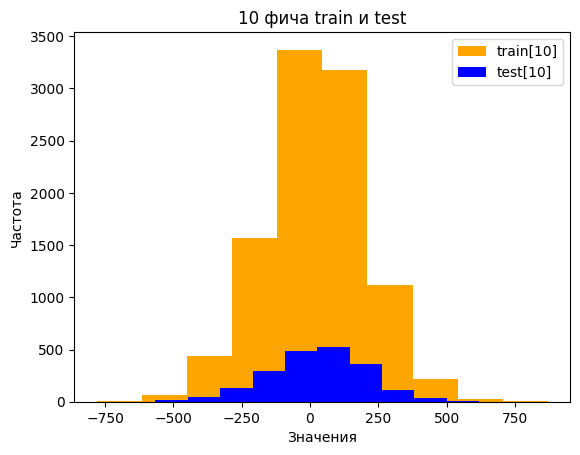

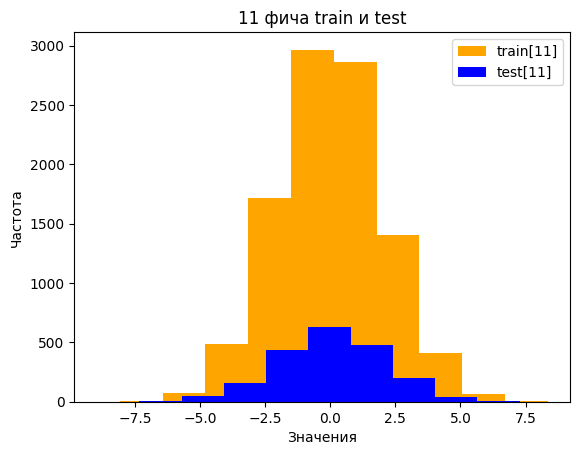

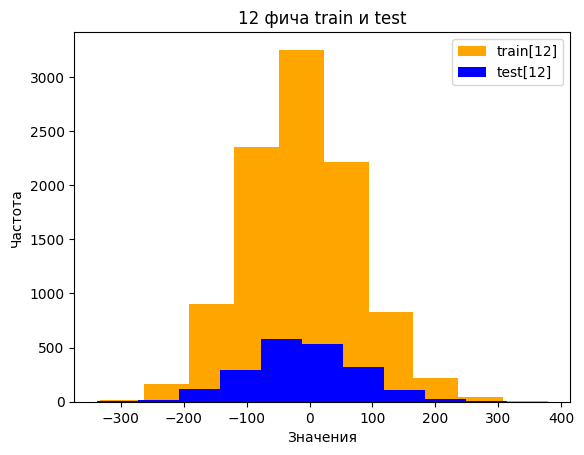

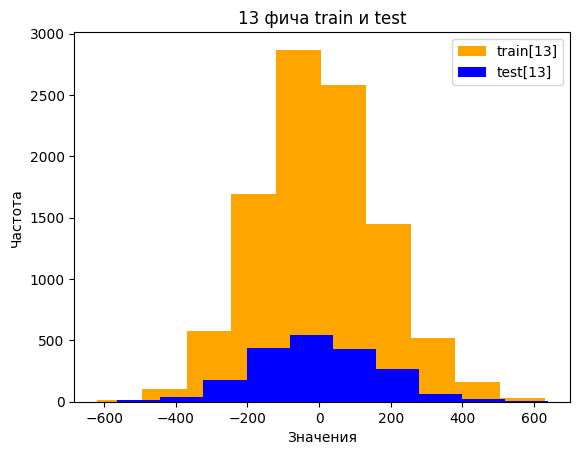

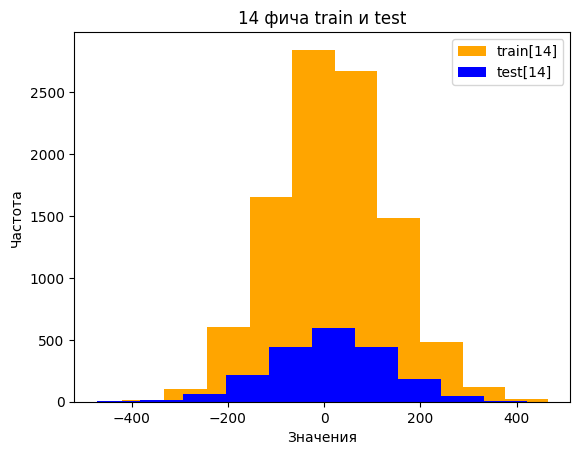

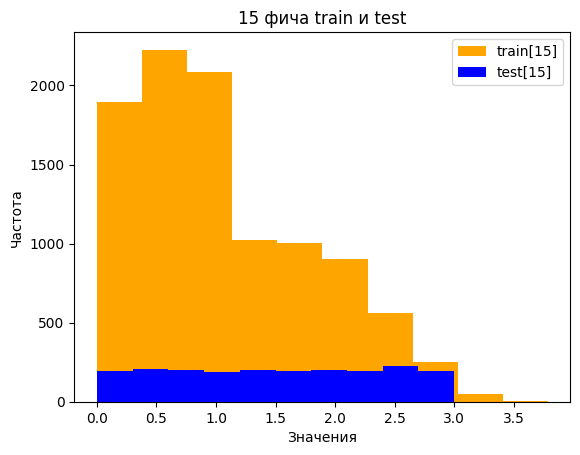

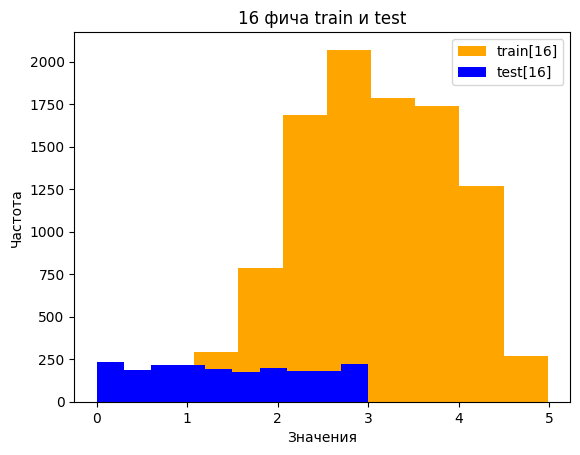

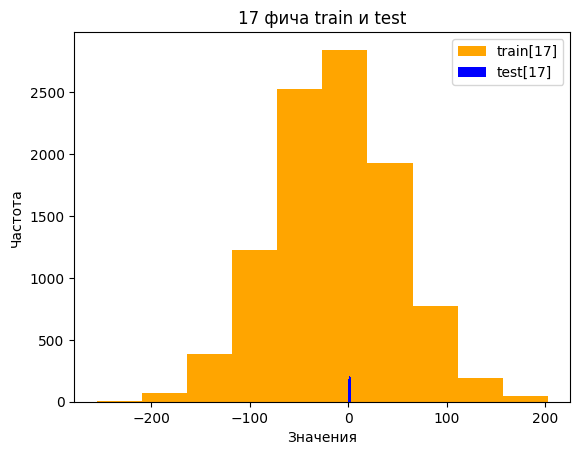

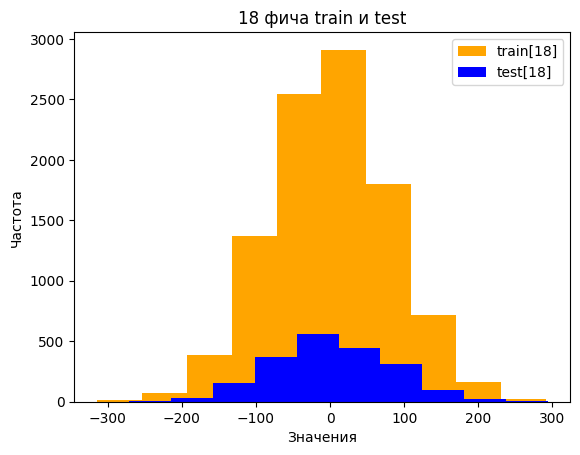

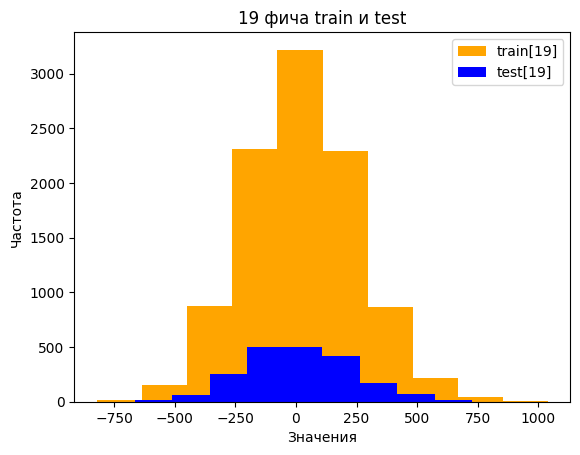

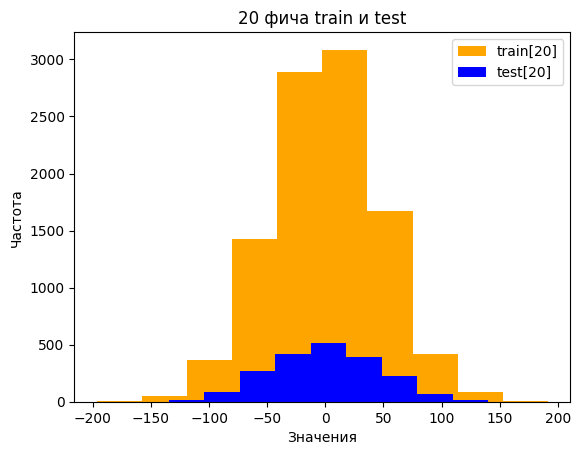

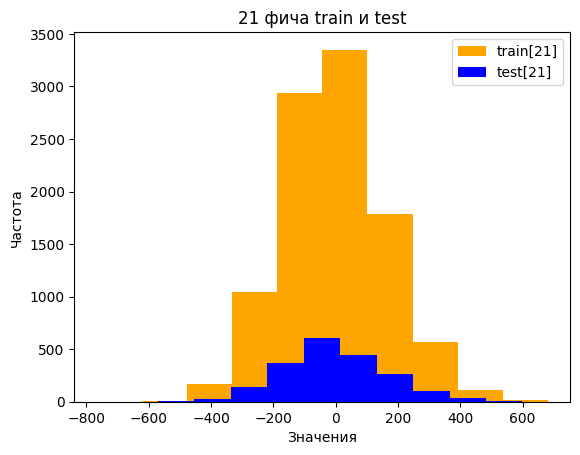

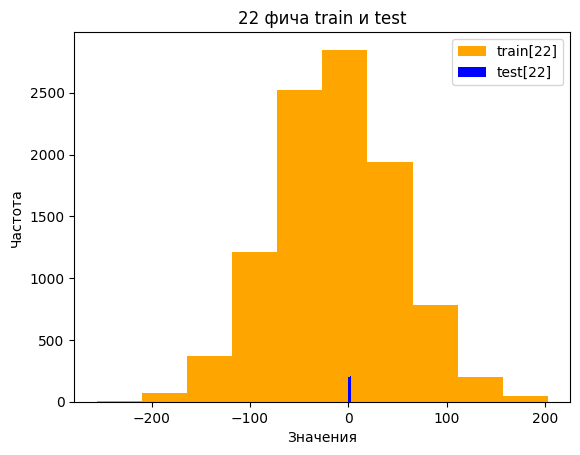

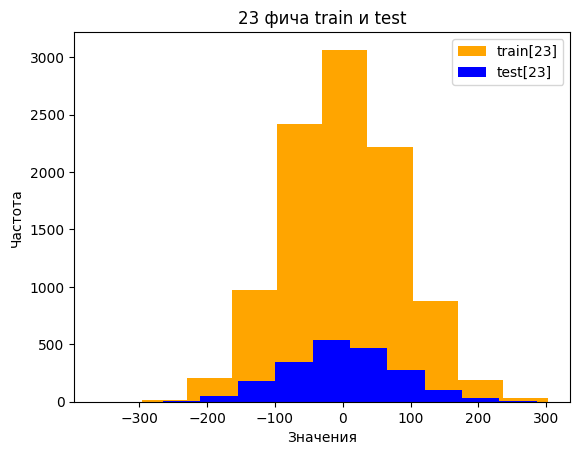

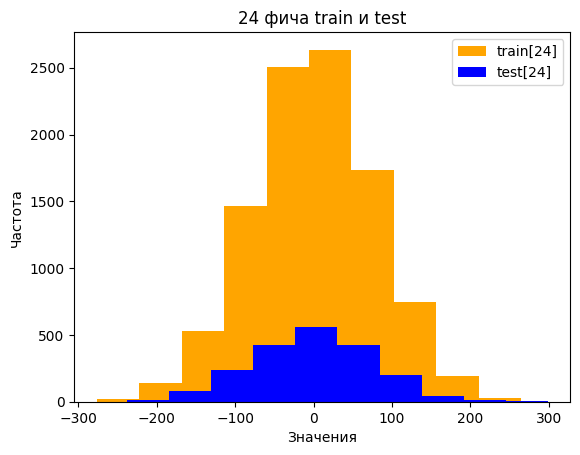

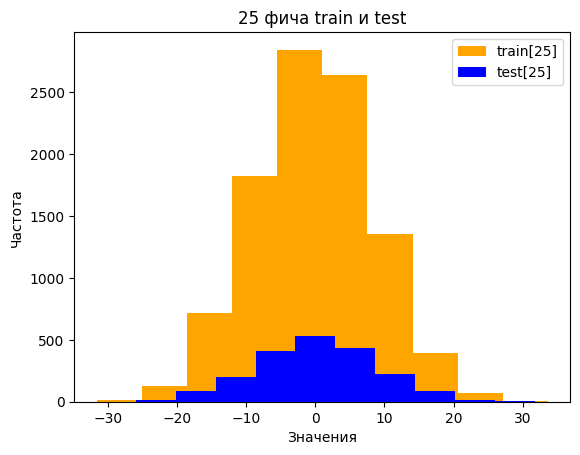

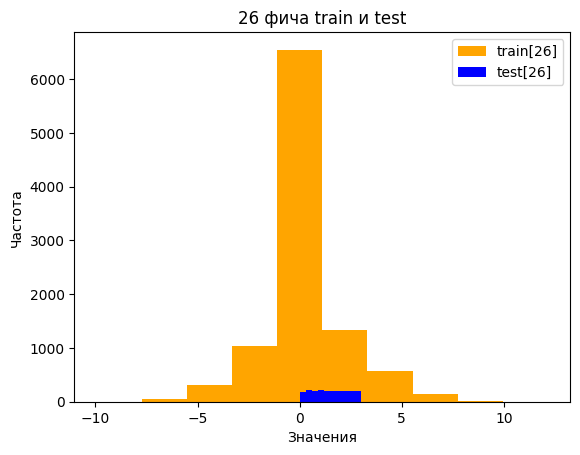

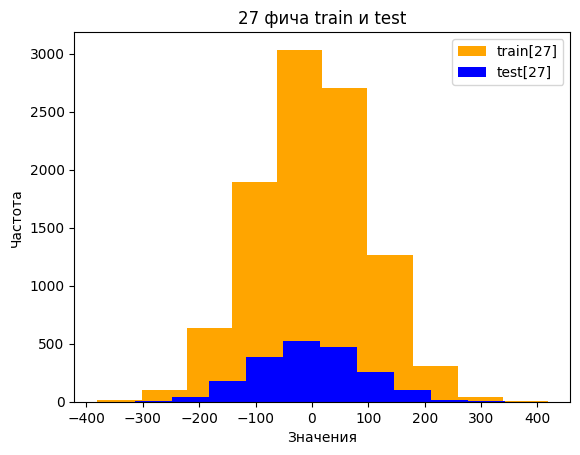

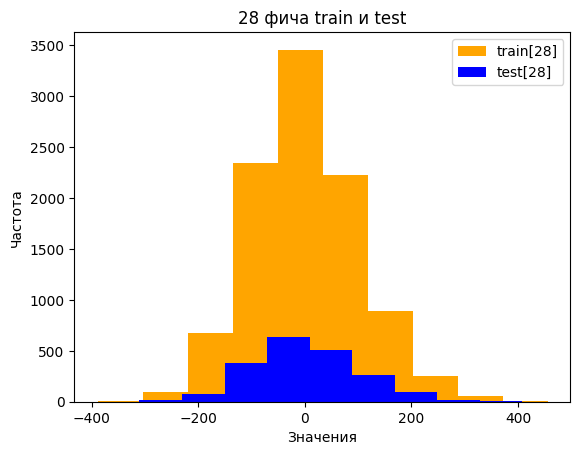

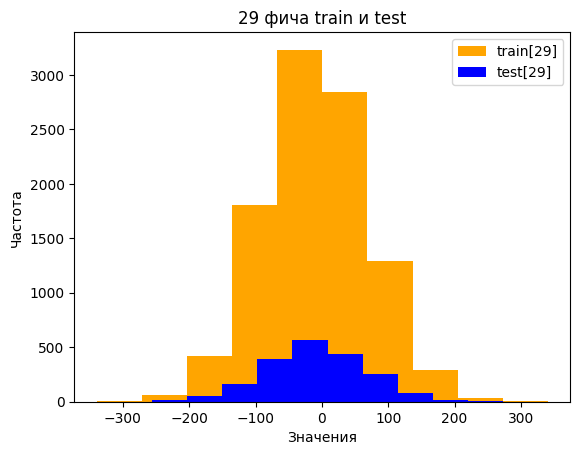

In [14]:
for i in range(30):
    plt.hist(df[str(i)], color='orange', label=f'train[{i}]')
    plt.hist(test_df[str(i)], color='blue', label=f'test[{i}]')

    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.title(f'{i} фича train и test')
    plt.legend()

    plt.show()

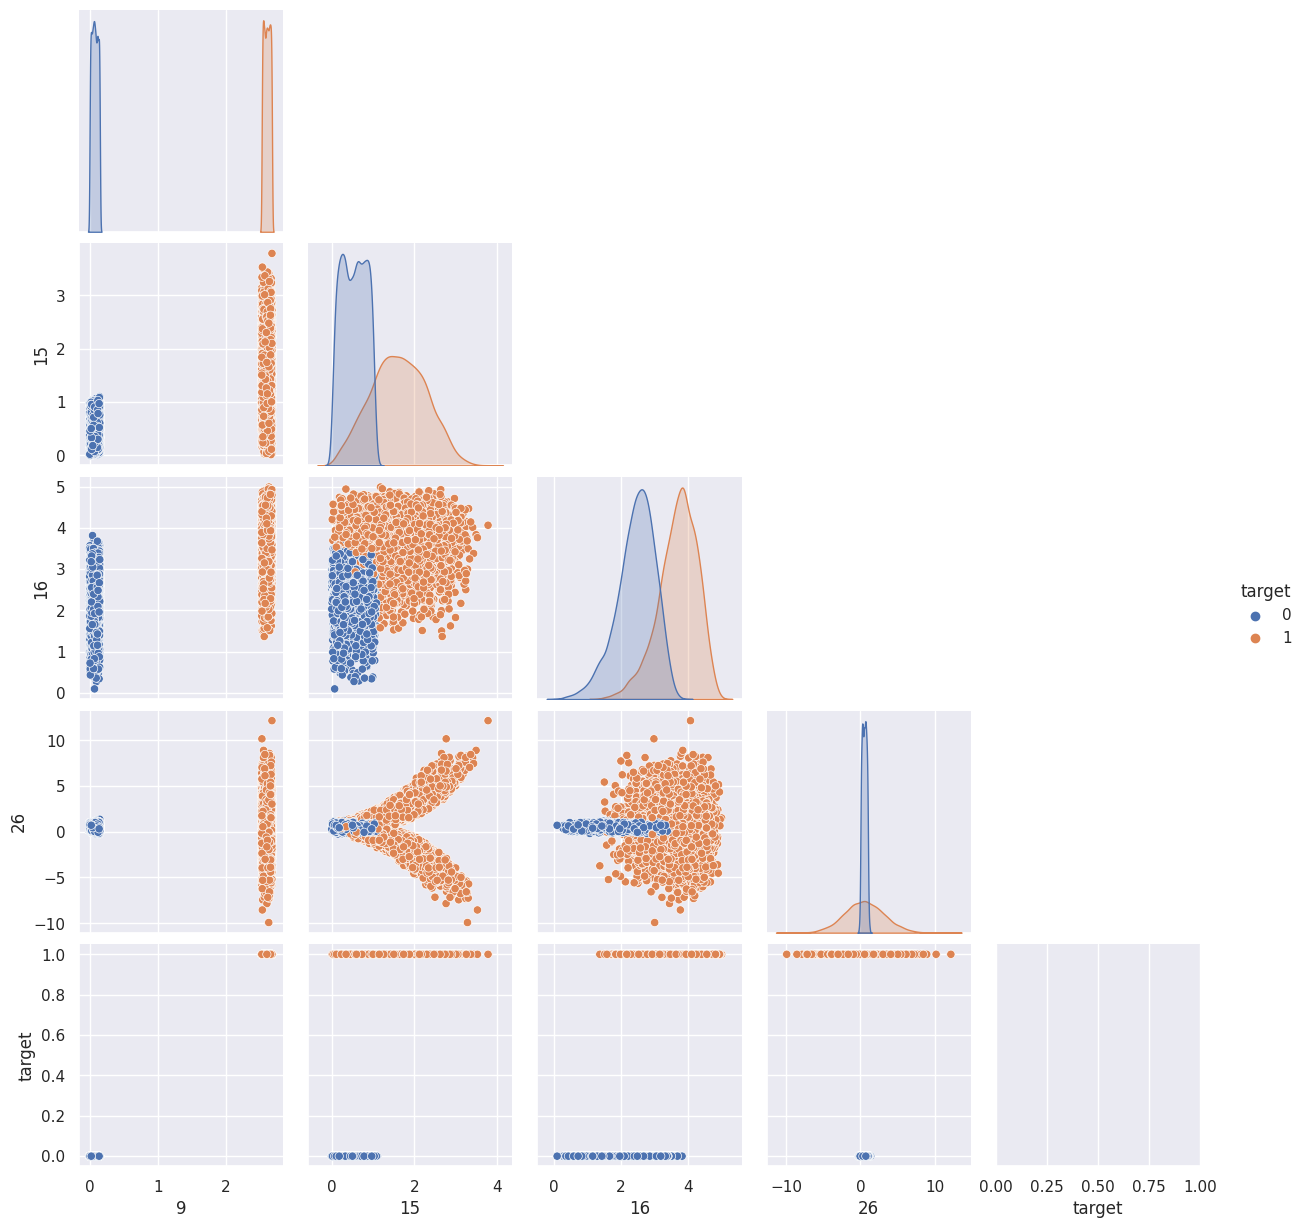

## Optuna (best_params)

In [ ]:
transform_df = df.drop(['9', '15', '16', '26'], axis=1)  # leak data
df_tt = transform_df.drop(['1', '3', '4', '11', '18', '20', '23', '24', '25', '27'], axis=1)
X = df_tt.drop(columns='target')
y = df_tt['target']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def objective_catboost(trial):
    X_train = transform_df.drop(columns='target')
    y_train = transform_df['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    param = {
        #"iterations": trial.suggest_int("iterations", 100, 1000),
        'iterations' : 1000, # Можно не перебирать, есть Early-Stopping
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),

        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
        "depth": trial.suggest_int("depth", 3, 9),

        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "14gb",
        "loss_function": 'Logloss',
        "eval_metric": "AUC", # Тоже стоит заранее определиться
    }
    params = {'iterations' : 1000, "used_ram_limit": "14gb", "loss_function": 'Logloss', "eval_metric": "AUC", 'learning_rate': 0.009575251555818785, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.5082361608626066, 'auto_class_weights': 'None', 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    clf = CatBoostClassifier(
        **param, thread_count=-1, random_seed=42
    )

    # Создаем объект callback
    pruning_callback = CatBoostPruningCallback(trial, "AUC")

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=0,
        plot=False,
        early_stopping_rounds=15,
        callbacks=[pruning_callback],
    )  # Добавляем callback в fit

    # запускаем процесс прунинга
    pruning_callback.check_pruned()

    y_pred = clf.predict(X_test)
    accuracy = roc_auc_score(y_pred, y_test)
    return accuracy

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize",
)

study.optimize(objective_catboost,
               n_trials=1000,
               n_jobs = -1,
               show_progress_bar=True,
              )

In [ ]:
print(study.best_params)

## Best_submitte

In [23]:
transform_df = df.drop(['9', '15', '16', '26'], axis=1)  # leak data
df_tt = transform_df.drop(['1', '3', '4', '11', '18', '20', '23', '24', '25', '27'], axis=1)

X = df_tt.drop(columns='target')
y = df_tt['target']


# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
params = {'iterations': 886, 'learning_rate': 0.006983523163319313, 'depth': 10, 'l2_leaf_reg': 11.660922016066483, 'bootstrap_type': 'Bayesian', 'random_strength': 2.3676764768135513e-05, 'bagging_temperature': 0.7602192265140637, 'od_type': 'Iter', 'od_wait': 34}
clf = CatBoostClassifier(
      **params,
      loss_function='Logloss',
      eval_metric='AUC'
)

# Обучение модели
clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, use_best_model = True)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)



0:	test: 0.7311262	best: 0.7311262 (0)	total: 94ms	remaining: 1m 23s
100:	test: 0.8163720	best: 0.8163720 (100)	total: 7.24s	remaining: 56.3s
200:	test: 0.8233795	best: 0.8233855 (199)	total: 11.6s	remaining: 39.5s
300:	test: 0.8274207	best: 0.8274207 (300)	total: 17.5s	remaining: 34s
400:	test: 0.8298746	best: 0.8298746 (400)	total: 23.3s	remaining: 28.2s
500:	test: 0.8320433	best: 0.8320433 (500)	total: 27.7s	remaining: 21.3s
600:	test: 0.8329360	best: 0.8330061 (585)	total: 33.1s	remaining: 15.7s
700:	test: 0.8336606	best: 0.8336606 (700)	total: 39.6s	remaining: 10.4s
800:	test: 0.8343882	best: 0.8343882 (800)	total: 44.1s	remaining: 4.68s
885:	test: 0.8347885	best: 0.8348345 (881)	total: 48.4s	remaining: 0us

bestTest = 0.8348345103
bestIteration = 881

Shrink model to first 882 iterations.


**Public:** 0.8271

Text(0.5, 1.0, 'Feature Importance')

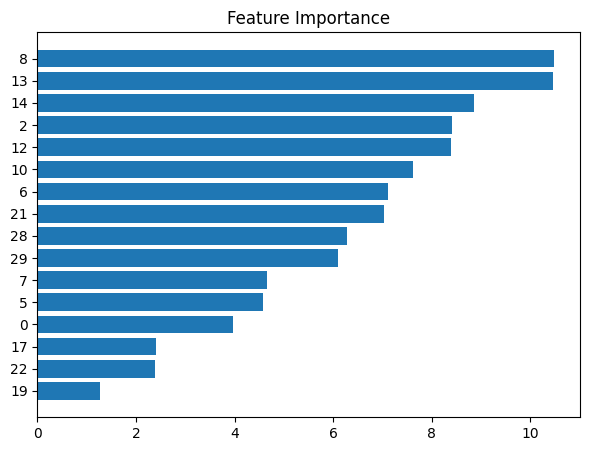

In [35]:
feature_importance = clf.get_feature_importance(prettified=True)
feature_importance_values = np.array(feature_importance['Importances']).astype(float)

sorted_idx = np.argsort(feature_importance_values)
fig = plt.figure(figsize=(7, 5))
plt.barh(range(len(sorted_idx)), feature_importance_values[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_importance['Feature Id'])[sorted_idx])
plt.title('Feature Importance')

# Research

### dop_funcions

In [ ]:
def function(x):  # threshold
     if x > 0.8:
          return 1
     elif x < 0.2:
         return 0
     else:
       return x

In [ ]:
def test_pred(model, file_name='sub_do', d=False, to_return=False): # submission
  test_df = pd.read_csv(link+'test.csv', header=None)
  train_df.rename(columns=lambda x: str(x), inplace=True)

  sample_sub = pd.read_csv(link+'sample-submission.csv', header=None)
  sample_sub.rename(columns=lambda x: str(x), inplace=True)
  test_df.rename(columns=lambda x: str(x), inplace=True)
  test_df['sum_in_row'] = test_df.apply(sum_in_row, axis=1)
  test_df['dop'] = (test_df['10'] + test_df['2']) / 7

  test_df = test_df.drop(['9', '15', '16', '26', '1', '3', '4', '11', '18', '20', '23', '24', '25', '27'], axis=1)
  if not to_return:
    if not d:
      sample_sub['0'] = model.predict_proba(test_df)[:, 1]
    else:
      sample_sub['0'] = model.predict(test_df)
    sample_sub['0'] = sample_sub['0'].apply(function)
    sample_sub.to_csv(f'{file_name}.csv', index=False, header=False)
  else:
    return model.predict_proba(test_df)[:, 1]

In [ ]:
def model_pred(df, name='toda', is_ret=False):  # fit
  X = df.drop(columns='target')
  y = df['target']

  # Разделение данных на обучающий и тестовый наборы
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # Создание объекта CatBoostClassifier с регуляризацией

  # params = {'iterations' : 1000, "used_ram_limit": "14gb", 'learning_rate': 0.009575251555818785, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.5082361608626066, 'auto_class_weights': 'None', 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
  params = {'iterations': 886, 'learning_rate': 0.006983523163319313, 'depth': 10, 'l2_leaf_reg': 11.660922016066483, 'bootstrap_type': 'Bayesian', 'random_strength': 2.3676764768135513e-05, 'bagging_temperature': 0.7602192265140637, 'od_type': 'Iter', 'od_wait': 34}
  clf = CatBoostClassifier(
      **params,
      loss_function='Logloss',
      eval_metric='AUC'
  )

  # Обучение модели
  clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, use_best_model = True)

  # Получение предсказаний для тестового набора
  y_pred_proba = clf.predict_proba(X_test)[:, 1]

  # Вычисление ROC-AUC
  roc_auc = roc_auc_score(y_test, y_pred_proba)
  print(f'ROC-AUC: {roc_auc}')
  clf.save_model(f'{name}.bin')

  if is_ret:
    return clf

## First_step (Baruto)

**Цель:** Использование Baruto для отсечения ненужных признаков.

In [ ]:


###initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1,
   max_depth = 3
)
boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
    verbose=1
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_train))
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	16
Rejected: 	0
features in the green area: []
features in the blue area: ['0', '2', '5', '6', '7', '8', '10', '12', '13', '14', '17', '19', '21', '22', '28', '29']
features in the red area: ['1', '3', '4', '11', '18', '20', '23', '24', '25', '27']


In [ ]:
df_tt = transform_df.drop(['1', '3', '4', '11', '18', '20', '23', '24', '25', '27'], axis=1)
model = model_pred(df_tt, 'toda_1', True)

0:	test: 0.7250932	best: 0.7250932 (0)	total: 34.4ms	remaining: 30.5s
100:	test: 0.8132418	best: 0.8132488 (99)	total: 3.09s	remaining: 24.1s
200:	test: 0.8230034	best: 0.8230034 (200)	total: 7.01s	remaining: 23.9s
300:	test: 0.8273533	best: 0.8273743 (294)	total: 12.6s	remaining: 24.5s
400:	test: 0.8291885	best: 0.8291885 (400)	total: 15.7s	remaining: 19s
500:	test: 0.8311709	best: 0.8311709 (500)	total: 18.7s	remaining: 14.4s
600:	test: 0.8322326	best: 0.8322476 (597)	total: 22s	remaining: 10.4s
700:	test: 0.8332113	best: 0.8332183 (697)	total: 26.6s	remaining: 7.02s
800:	test: 0.8338897	best: 0.8338897 (800)	total: 29.6s	remaining: 3.15s
885:	test: 0.8343840	best: 0.8344611 (883)	total: 32.2s	remaining: 0us

bestTest = 0.8344610957
bestIteration = 883

Shrink model to first 884 iterations.
ROC-AUC: 0.8344610957006937


Вывод: 0.8266083064332257 (good)

## Second_step (T-SNE)

**Цель:** Визуализировать данные на T-SNE, довобление новых признаков.

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(n_components=3, random_state=42)
tsr = tsne.fit_transform(df_tt.drop(['target'], axis=1))

# Создаем новые столбцы в DataFrame для новых признаков, полученных с помощью t-SNE
df_tt['tsne_feature1'] = tsr[:, 0]
df_tt['tsne_feature2'] = tsr[:, 1]
df_tt['tsne_feature3'] = tsr[:, 2]
df_tt.head()

,0,2,5,6,7,8,10,12,13,14,17,19,21,22,28,29,target,tsne_feature1,tsne_feature2,tsne_feature3
0,-220.530530,119.035181,52.225051,-23.230903,-166.521871,-41.571463,271.292251,44.529272,12.998666,25.157748,-81.684213,-36.818566,46.543585,-80.962171,-37.942655,33.838225,1,-12.996106,0.263188,-10.481623
1,-8.536541,-117.828269,-42.087807,-45.538664,58.898976,27.749744,-97.233793,-104.382283,2.867261,-128.433975,31.501910,103.060202,121.304258,31.507396,-52.255449,-4.826111,1,-3.386127,2.599910,-1.540379
2,126.229973,-105.511797,-104.302244,5.815395,100.838385,-46.240211,194.054804,-145.510845,86.972373,-126.200888,51.084960,-150.020696,88.905713,51.475105,-107.835928,-93.990332,0,3.784791,-15.756617,12.606818
3,369.571563,-299.969407,-115.901854,159.134323,-149.741411,-108.847522,-215.802195,-128.050861,-99.997710,138.824836,-73.956562,310.894782,-166.476192,-73.882682,121.674228,-16.877368,0,17.315212,13.918598,-0.162092
4,-99.563708,-73.363391,-54.892519,56.430532,-49.237377,-50.054608,-115.997344,97.666751,36.416791,-124.206264,-23.264695,121.929801,209.163125,-22.847302,3.492953,-15.799596,1,-2.059673,13.078748,13.791647


In [ ]:
res = tsne.fit_transform(test_df)

test_df['tsne_feature1'] = res[:, 0]
test_df['tsne_feature2'] = res[:, 1]
test_df['tsne_feature3'] = res[:, 2]

test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,tsne_feature1,tsne_feature2,tsne_feature3
0,394.650101,-102.778703,-48.854416,17.463193,4.744214,-90.504260,135.111157,-27.691507,192.961067,1.755201,...,11.483086,-131.665132,12.876561,0.156747,-185.849095,-29.314711,-84.254441,-11.757137,-11.566517,-2.913478
1,62.200701,-139.323500,235.644493,10.860594,1.921110,39.088440,-186.024836,-53.158605,-122.290561,1.426944,...,-24.895114,-40.050598,7.376349,1.962719,-123.776910,65.756136,-10.378203,6.800809,15.053272,-3.297734
2,232.736729,5.502143,204.738165,45.738959,1.338264,33.604743,92.235943,-115.127927,-95.263085,2.048801,...,286.011182,48.109151,-9.277772,1.838195,19.461847,126.144518,-121.300353,-8.228889,10.082538,-10.005237
3,340.045437,-129.924115,62.694027,61.899097,-1.294288,-58.616589,-55.080664,10.115134,9.051856,2.732693,...,70.875892,26.673509,2.389621,2.188665,109.700845,109.378365,-58.425305,-9.612288,6.265561,4.453664
4,-60.576957,71.958472,489.203093,121.380719,-3.620431,44.666983,-161.487192,137.920737,540.680255,1.172919,...,-21.814728,-91.701674,-9.206418,1.211916,-11.602746,-8.162451,-87.902970,9.319673,11.217641,-11.095026


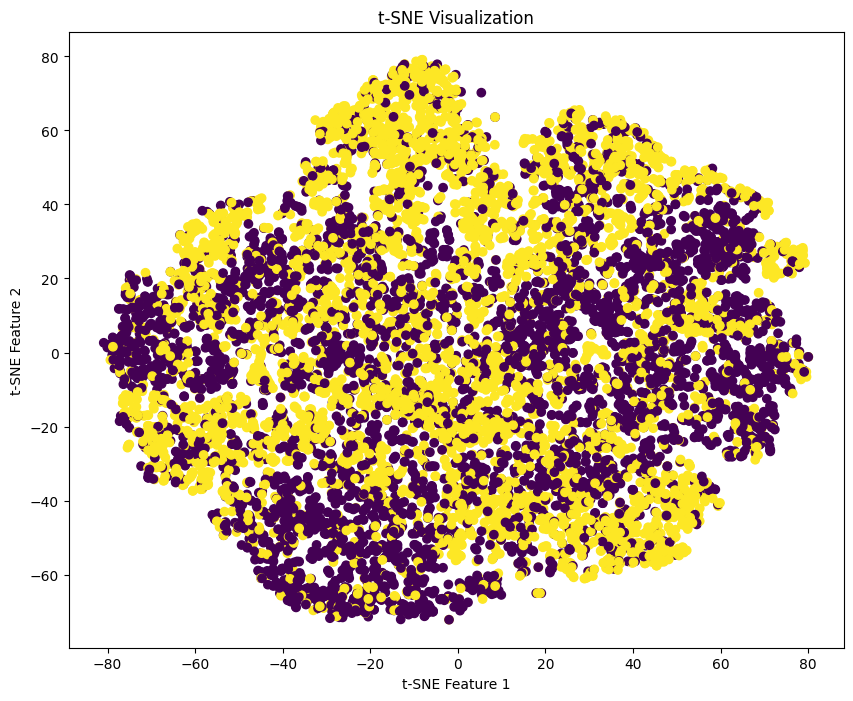

In [ ]:
# Разделяем данные на классы (если у вас есть метки классов)
class_labels = df_tt['target']

# Визуализация с использованием matplotlib
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(df_tt['tsne_feature1'], df_tt['tsne_feature2'], c=class_labels, cmap='viridis')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')

plt.show()

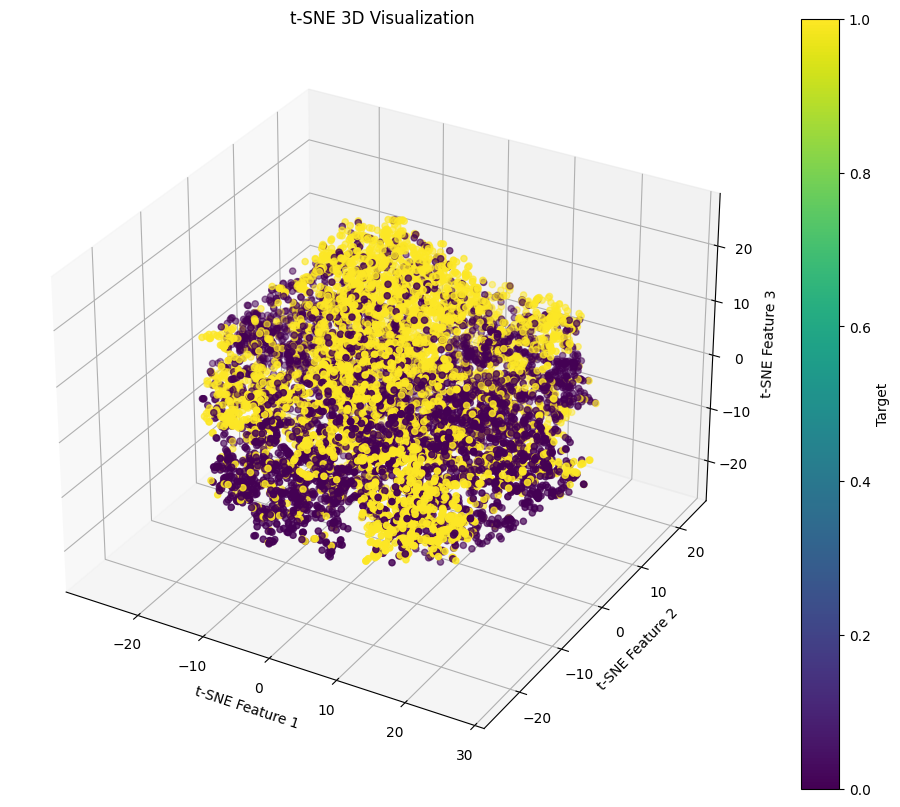

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Предположим, что tsne_model - это ваша обученная модель t-SNE
# df - это ваш DataFrame с данными, включая новые признаки t-SNE

# Создаем трехмерный scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_tt['tsne_feature1'], df_tt['tsne_feature2'], df_tt['tsne_feature3'], c=df_tt['target'], cmap='viridis')

# Добавляем метки осей и заголовок
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_zlabel('t-SNE Feature 3')
ax.set_title('t-SNE 3D Visualization')

# Добавляем цветовую шкалу
fig.colorbar(scatter, ax=ax, label='Target')

plt.show()

In [ ]:
model = model_pred(df_tt, 'toda_1', True)

In [ ]:
model = model
sample_sub = pd.read_csv(link+'sample-submission.csv', header=None)
sample_sub.rename(columns=lambda x: str(x), inplace=True)
test_df.rename(columns=lambda x: str(x), inplace=True)

sample_sub['0'] = model.predict_proba(test_df.drop(['9', '15', '16', '26'], axis=1))[:, 1]
def function(x):
    if x > 0.8:
        return 1
    elif x < 0.2:
        return 0
    else:
      return x
sample_sub['0'] = sample_sub['0'].apply(function)
sample_sub.to_csv('submit2.csv', index=False, header=False)

Вывод: 0.8138637554550217 (плохо)

## Third_step (Models + Optuna)

**Цель:** Сравнить разные модели ML для лучшего понимания, куда двигаться

- Экстримальный случайный лес (ExtraTreesClassifier)
- Метод k ближайших соседей (KNeighborsClassifier)
- Light_GBM
- XGBModel


In [54]:
X = df_tt.drop(columns='target')
y = df_tt['target']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier

### KNN

In [ ]:
def objective(trial):

    # -- Tune estimator algorithm
    n_neighbors = trial.suggest_int("n_neighbors", 1, 600)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

    knn.fit(X_train, y_train)

    # -- Cross-validate the features reduced by dimensionality reduction methods
    preds = knn.predict(X_test)
    acc = roc_auc_score(y_test, preds)
    return acc

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize",
)

study.optimize(objective,
               n_trials=600,
               n_jobs = -1,
               show_progress_bar=True,
              )

In [ ]:
print(study.best_params)

{'n_neighbors': 182, 'weights': 'distance', 'metric': 'manhattan'}


In [56]:
model1 = KNeighborsClassifier(
   n_neighbors=54, weights='distance', metric='manhattan'
)

model1.fit(X_train, y_train)
test_pred(model1, 'knn')
dump(model1, 'model1.joblib')

['model1.joblib']

### XGBoost

In [ ]:
from optuna.integration import XGBoostPruningCallback

def objective(trial):
    X_train = transform_df.drop(columns='target')
    y_train = transform_df['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    param = {
        "eval_metric": "auc",
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, 100),
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_int('reg_lambda', 5, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }

    model = XGBClassifier(random_state=dseed,
                             tree_method='gpu_hist',
                             gpu_id=0,
                             predictor="gpu_predictor"
                             ,**param )

    # Создаем объект callback
    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-auc')

    model.fit(X_train, y_train,eval_set=[(X_test,y_test)], early_stopping_rounds=100,verbose=False,
              callbacks=[pruning_callback],)

    preds = model.predict(X_test)
    acc = roc_auc_score(y_test, preds)
    return acc

In [ ]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction='maximize')
study.optimize(objective, n_trials=600, n_jobs = -1,
               show_progress_bar=True,)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
print(study.best_params)

In [ ]:
param = param = {
        "eval_metric": "auc",
        'max_depth': 10,
        'subsample': 0.9,
        'n_estimators': 4000,
        'eta': 0.03,
        'reg_alpha': 24,
        'reg_lambda': 73,
        'min_child_weight': 15,
        "colsample_bytree": 0.4,
    }
model2 = XGBClassifier(random_state=dseed,
                             tree_method='gpu_hist',
                             gpu_id=0,
                             predictor="gpu_predictor"
                             ,**param )

model2.fit(X_train, y_train)
test_pred(model2, 'XGBoost.csv')

### Light_GBM

In [ ]:
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    roc_auc = roc_auc_score(y_test, pred_labels)
    return roc_auc

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=12)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=600, show_progress_bar=True)

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
print(study.best_params)

{'lambda_l1': 1.0228668163586668e-08, 'lambda_l2': 2.039437051144921e-08, 'num_leaves': 160, 'feature_fraction': 0.9750190043215184, 'bagging_fraction': 0.9704331276451077, 'bagging_freq': 2, 'min_child_samples': 5}


In [57]:
dtrain = lgb.Dataset(X_train, label=y_train)

In [ ]:
# param = {'lambda_l1': 1.0228668163586668e-08, 'lambda_l2': 2.039437051144921e-08, 'num_leaves': 160, 'feature_fraction': 0.9750190043215184, 'bagging_fraction': 0.9704331276451077, 'bagging_freq': 2, 'min_child_samples': 5}
model3 = lgb.LGBMClassifier(random_state=15,
    num_leaves = 102,
    min_child_samples = 35,
    colsample_bytree=0.8936609435832564,
    reg_alpha=5.362921871649662,
    reg_lambda=0.020147919618071247,
    subsample=0.849787258254075,
    subsample_freq=1)
model3.fit(X_train, y_train)
test_pred(model3, 'gbm_light')
dump(model3, 'model3.joblib')

### ExtraTreesClassifier

In [ ]:
def objective(trial):
    model = ExtraTreesClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 1000),
        max_depth=trial.suggest_int('max_depth', 4, 50),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 150),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 60),
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=12)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=600, show_progress_bar=True)

In [ ]:
print(study.best_params)

{'n_estimators': 801, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1}


In [59]:
param = {'n_estimators': 801, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1}
model4 = ExtraTreesClassifier(**param)

model4.fit(X_train, y_train)
test_pred(model4, 'extrTree.csv')
dump(model4, 'model4.joblib')

['model4.joblib']

## Forth_step (MLP)

- **Цель:** Обучить модель нейронной сети, для добавления эмбедингов в генеральную совокупность.
- **Вывод:** не помогло

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from datetime import datetime
from sklearn.preprocessing import StandardScaler

class MyDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.Tensor(self.data.iloc[idx].values)
        y = torch.Tensor([self.target.iloc[idx]])
        return x, y

data = df_tt[(i for i in df_tt.columns if i != 'target')]
target = df_tt['target']

scaler = StandardScaler()
data = scaler.fit_transform(data)

data = pd.DataFrame(data)

train_dataset = MyDataset(data, target)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [37]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=42)

def Block(input_size, out_size):
    return nn.Sequential(
        nn.Linear(input_size, out_size),
        nn.LeakyReLU(),
        nn.BatchNorm1d(out_size),
    )

def BlockWithoutBN(input_size, out_size):
    return nn.Sequential(
        nn.Linear(input_size, out_size),
        nn.LeakyReLU(),
    )

class mlp(nn.Module):
    def __init__(self):
        super().__init__()
        #self.fc1 = Block(26, 24)
        #self.drop = nn.Dropout1d(0.2)
        #self.fc2 = nn.Linear(24, 24)
        #self.drop = nn.Dropout1d(0.2)
        #self.classifier = nn.Linear(24, 1)
        self.fc1 = Block(16, 24)
        self.drop = nn.Dropout1d(0.2)
        self.fc2 = Block(24, 24)
        self.fc3 = Block(24, 21)
        self.classifier = Block(21, 1)
        #self.fc4 = Block(6, 3)
        #self.fc5 = nn.Linear(3, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.drop(out)
        out = self.fc3(out)
        out = self.classifier(out)
        #out = self.fc4(out)
        return out

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = None
    alpha = 0.8
    for iteration, load in enumerate(loader):
        optimizer.zero_grad()
        data, target = load
        data = data.to('cpu')
        target = target.to('cpu')
        pred_logits = model(data)
        pred_probs = torch.sigmoid(pred_logits)
        ce_loss = criterion(pred_logits, target)
        ce_loss.backward()
        optimizer.step()

        if running_loss is None:
            running_loss = ce_loss.item()
        else:
            running_loss = alpha * ce_loss.item() + (1 - alpha) * ce_loss.item()
        if iteration % 100 == 0:
            print('   {} batch {} loss {}'.format(
                datetime.now(), iteration + 1, running_loss
            ))

In [38]:
model3 = mlp().to('cpu')
optimizer = torch.optim.AdamW(model3.parameters(), lr=3e-04)
criterion = nn.BCEWithLogitsLoss()

epochs = 10 # ? - the best

#lossv, accv = [], []
for epoch in tqdm(range(epochs)):
    train_epoch(model3, train_dataloader, criterion, optimizer)
    #predict(lossv, accv)



  0%|          | 0/10 [00:00<?, ?it/s]

   2023-12-08 15:15:40.367921 batch 1 loss 0.8153303265571594
   2023-12-08 15:15:41.137907 batch 101 loss 0.7015595436096191


 10%|█         | 1/10 [00:01<00:12,  1.44s/it]

   2023-12-08 15:15:41.621706 batch 1 loss 0.6468761563301086
   2023-12-08 15:15:42.405455 batch 101 loss 0.7479351758956909


 20%|██        | 2/10 [00:02<00:10,  1.32s/it]

   2023-12-08 15:15:42.857837 batch 1 loss 0.5672407150268555
   2023-12-08 15:15:43.634968 batch 101 loss 0.7196028828620911


 30%|███       | 3/10 [00:03<00:08,  1.28s/it]

   2023-12-08 15:15:44.082932 batch 1 loss 0.5925434827804565
   2023-12-08 15:15:44.853135 batch 101 loss 0.5566665530204773


 40%|████      | 4/10 [00:05<00:07,  1.25s/it]

   2023-12-08 15:15:45.291911 batch 1 loss 0.6275070905685425
   2023-12-08 15:15:46.082503 batch 101 loss 0.600826621055603


 50%|█████     | 5/10 [00:06<00:06,  1.25s/it]

   2023-12-08 15:15:46.542459 batch 1 loss 0.6474109888076782
   2023-12-08 15:15:47.323919 batch 101 loss 0.607340931892395


 60%|██████    | 6/10 [00:07<00:04,  1.25s/it]

   2023-12-08 15:15:47.784227 batch 1 loss 0.6532629728317261
   2023-12-08 15:15:48.582888 batch 101 loss 0.7106677889823914


 70%|███████   | 7/10 [00:09<00:03,  1.30s/it]

   2023-12-08 15:15:49.199303 batch 1 loss 0.5418358445167542
   2023-12-08 15:15:50.351018 batch 101 loss 0.5812046527862549


 80%|████████  | 8/10 [00:10<00:02,  1.47s/it]

   2023-12-08 15:15:51.027300 batch 1 loss 0.5612870454788208
   2023-12-08 15:15:52.202052 batch 101 loss 0.6455362439155579


 90%|█████████ | 9/10 [00:12<00:01,  1.59s/it]

   2023-12-08 15:15:52.886527 batch 1 loss 0.6273576617240906
   2023-12-08 15:15:54.021863 batch 101 loss 0.5794591307640076


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


In [42]:
model3.classifier = torch.nn.Identity()
model3.to('cpu')
model3.eval()

mlp(
  (fc1): Sequential(
    (0): Linear(in_features=16, out_features=24, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop): Dropout1d(p=0.2, inplace=False)
  (fc2): Sequential(
    (0): Linear(in_features=24, out_features=24, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc3): Sequential(
    (0): Linear(in_features=24, out_features=21, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Identity()
)

In [45]:
# Собираем эмбеддинги в список
embeddings = []

with torch.no_grad():
    for inputs, labels_1 in train_dataloader:
        inputs = inputs.to('cpu')
        outputs = model3(inputs)
        embeddings.extend(outputs.detach().cpu().numpy())

In [46]:
# Преобразуем list в датафрейм с эмбеддингами
embed_df = pd.DataFrame(data=embeddings,
                        columns=[f'embed_{i}' for i in range(embeddings[0].shape[0])])
embed_df.head()

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20
0,-0.147184,0.173953,-0.571370,-0.596945,-0.136549,-0.501895,-0.281894,-0.559922,0.548898,-0.478340,...,-0.287768,-0.601878,-0.300524,0.772445,-0.420415,-0.724922,-0.576628,0.285542,0.310294,-0.266672
1,-0.954929,-0.692946,-0.575771,0.055378,-0.472258,0.185636,-0.779198,-0.561854,-0.322914,0.104605,...,-0.185630,-0.284950,-0.299646,0.218718,-0.520144,-0.394392,-0.567811,0.020043,-0.597815,-0.255389
2,-0.916697,0.748723,-0.242233,-0.732413,-0.024882,0.995026,0.425610,-0.415620,0.473508,-0.479185,...,-0.600979,-0.611032,-0.297412,-0.686588,1.024330,-0.721261,-0.574176,-0.892062,0.669432,-0.142466
3,3.270106,0.127716,0.831760,1.224921,-0.642543,-0.846351,-0.431478,-0.583068,1.265944,-0.262959,...,-0.195816,0.326330,2.151941,-0.243619,1.282251,-0.740299,-0.582378,2.448614,-0.620693,-0.285455
4,0.039742,-0.687524,-0.579214,-0.126894,-0.615289,-0.832505,0.134571,-0.107513,-0.558764,1.413743,...,-0.539238,0.027516,-0.318155,0.639796,-0.505724,1.124705,-0.571181,-0.841470,-0.629331,0.226073


0:	test: 0.7332622	best: 0.7332622 (0)	total: 162ms	remaining: 2m 23s
100:	test: 0.8156124	best: 0.8156124 (100)	total: 10.1s	remaining: 1m 18s
200:	test: 0.8224039	best: 0.8224460 (199)	total: 22.5s	remaining: 1m 16s
300:	test: 0.8261175	best: 0.8261265 (296)	total: 37.5s	remaining: 1m 12s
400:	test: 0.8279027	best: 0.8279167 (398)	total: 53s	remaining: 1m 4s
Stopped by overfitting detector  (34 iterations wait)

bestTest = 0.8279566987
bestIteration = 415

Shrink model to first 416 iterations.
ROC-AUC: 0.8279566987283404


Text(0.5, 1.0, 'Feature Importance')

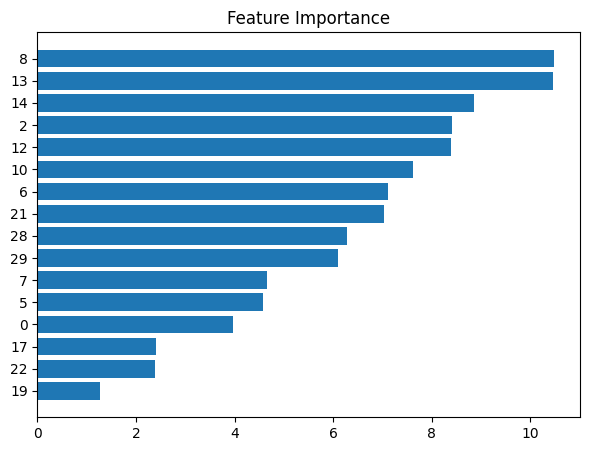

In [47]:
# Присоединяем эмбединги к трэйн датасету
df_m = pd.concat((df_tt, embed_df) ,axis=1)
model = model_pred(df_m, 'toda_1', True)

feature_importance = clf.get_feature_importance(prettified=True)
feature_importance_values = np.array(feature_importance['Importances']).astype(float)

sorted_idx = np.argsort(feature_importance_values)
fig = plt.figure(figsize=(7, 5))
plt.barh(range(len(sorted_idx)), feature_importance_values[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_importance['Feature Id'])[sorted_idx])
plt.title('Feature Importance')

In [48]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.Tensor(self.data.iloc[idx].values)
        return x

test_df = pd.read_csv(link+'test.csv', header=None)
train_df.rename(columns=lambda x: str(x), inplace=True)
sample_sub = pd.read_csv(link+'sample-submission.csv', header=None)
sample_sub.rename(columns=lambda x: str(x), inplace=True)
test_df.rename(columns=lambda x: str(x), inplace=True)
test_df = test_df.drop(['9', '15', '16', '26', '1', '3', '4', '11', '18', '20', '23', '24', '25', '27'], axis=1)
test_df_scaled = scaler.transform(test_df)
test_df_scaled_pd = pd.DataFrame(test_df_scaled)

test_dataset2 = MyDataset(test_df_scaled_pd.copy())
test_dataloader2 = DataLoader(test_dataset2, shuffle=False)

embeddings = []
with torch.no_grad():
    for inputs in test_dataloader2:
        inputs = inputs.to('cpu')
        outputs = model3(inputs)
        embeddings.extend(outputs.detach().cpu().numpy())
embed_df = pd.DataFrame(data=embeddings,
                        columns=[f'embed_{i}' for i in range(embeddings[0].shape[0])])
df_res = pd.concat((test_df, embed_df) ,axis=1)
res = model.predict_proba(df_res)[:, 1]

sample_sub['0'] = res
sample_sub.to_csv(f'pam.csv', index=False, header=False)

**Public:** 0.82101

## Fifth_step (blending, score + 0.02)

**Цель:** Собрать модели в каскад, сделать блендинг и K-fold обучение CatBoost

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=15)

for fold, (train_idx, test_idx) in enumerate(kf.split(df_tt)):
    print(f'Fold {fold + 1}, {fold+1}')

    # Разделите данные на обучающий и тестовый наборы
    train_data = df_tt.iloc[train_idx]


    X = train_data.drop(columns='target')
    y = train_data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

    params = {'iterations': 886, 'learning_rate': 0.006983523163319313, 'depth': 10, 'l2_leaf_reg': 11.660922016066483, 'bootstrap_type': 'Bayesian', 'random_strength': 2.3676764768135513e-05, 'bagging_temperature': 0.7602192265140637, 'od_type': 'Iter', 'od_wait': 34}
    clf = CatBoostClassifier(
      **params,
      loss_function='Logloss',
      eval_metric='AUC'
    )

    clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, use_best_model = True)

    # Получение предсказаний для тестового набора
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Вычисление ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f'ROC-AUC: {roc_auc}')
    clf.save_model(f'cat_{fold + 1}.bin')

In [ ]:
cat_1 = clf.load_model('cat_1.bin')
cat_2 = clf.load_model('cat_2.bin')
cat_3 = clf.load_model('cat_3.bin')
cat_4 = clf.load_model('cat_4.bin')
cat_5 = clf.load_model('cat_5.bin')

In [ ]:
# bagging with weights (depends on impact of model)
pred_logits_1 = (test_pred(cat_1, to_return=True) + test_pred(cat_2, to_return=True) + test_pred(cat_3, to_return=True) + test_pred(cat_4, to_return=True) + test_pred(cat_5, to_return=True)) / 5
sample_sub = pd.read_csv(link+'sample-submission.csv', header=None)
sample_sub.rename(columns=lambda x: str(x), inplace=True)
sample_sub['0'] = pred_logits_1
sample_sub['0'] = sample_sub['0'].apply(function)
sample_sub.to_csv(f'kfold.csv', index=False, header=False)

Блендинг

In [61]:
params = {'iterations': 886, 'learning_rate': 0.006983523163319313, 'depth': 10, 'l2_leaf_reg': 11.660922016066483, 'bootstrap_type': 'Bayesian', 'random_strength': 2.3676764768135513e-05, 'bagging_temperature': 0.7602192265140637, 'od_type': 'Iter', 'od_wait': 34}
clf = CatBoostClassifier(
      **params,
      loss_function='Logloss',
      eval_metric='AUC'
  )

In [62]:
cb_model = clf.load_model('toda_1.bin')
knn_model = load('model1.joblib')
extree_model = load('model4.joblib')

f1 = test_pred(cb_model, to_return=True)
f2 = test_pred(knn_model, to_return=True)
f3 = test_pred(extree_model, to_return=True)

pred_logits_2 = f1 * 0.7 + f2 * 0.1 + f3 * 0.20
sample_sub = pd.read_csv(link+'sample-submission.csv', header=None)
sample_sub.rename(columns=lambda x: str(x), inplace=True)
sample_sub['0'] = pred_logits_2
sample_sub['0'] = sample_sub['0'].apply(function)
sample_sub.to_csv(f'blending.csv', index=False, header=False)